In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
import torch


In [120]:
# This line will get passed in the 
cfg = {'data_path': '/mnt/ssd-cluster/ben/data/full_dataset/', #############################
    'json_path': '/home/ben/reef-audio-representation-learning/data/dataset.json',
    'train_percent': 0.2,
    'test_dataset': 'test_indonesia',
    'batch_size':64,
    'num_workers': 4,
    'device': 'cuda'}

In [149]:
### This file is a direct copy of the my_custom_dataset.py file in the models folder, but I've changed it to also return
#    the label as well as the tensor. Could streamline this by editing that original file to do this if its testing but
#    and not if its training, but being lazy for now and just making a whole new script.

import torch
import os
import json
import librosa
import numpy as np
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from sklearn.utils import class_weight

# for my transformations
#import librosa
from audiomentations import Compose, AddGaussianNoise, PitchShift, TimeStretch, ClippingDistortion, Gain, SevenBandParametricEQ


def resize_mel_spectrogram(mel_spec, desired_shape=(224, 224)):
    # Convert the 2D Mel spectrogram to 4D tensor (batch, channels, height, width)
    mel_spec_tensor = torch.tensor(mel_spec).unsqueeze(0).unsqueeze(0)
    # Resize
    resized_mel_spec = F.interpolate(mel_spec_tensor, size=desired_shape, mode='bilinear', align_corners=False)
    return resized_mel_spec.squeeze(0).squeeze(0).numpy()

# augmentation
augment_raw_audio = Compose(
    [
        AddGaussianNoise(min_amplitude=0.0001, max_amplitude=0.0005, p=1), # good
        PitchShift(min_semitones=-2, max_semitones=12, p=0.5), #set values so it doesnt shift too low, rmeoving bomb signal
        TimeStretch(p = 0.5), # defaults are fine
        ClippingDistortion(0, 5, p = 0.5), # tested params to make sure its good
        Gain(-10, 5, p = 0.5), # defaults are fine
        # throws an error, so i commented it out
        #SevenBandParametricEQ(-12, 12, p = 0.5)
    ]
)

# Modify the load_audio_and_get_mel_spectrogram function:
def mel_spectrogram_func(filename, augment, sr=8000, n_mels=128, n_fft=1024, hop_length=64, win_length=512):
    y, _ = librosa.load(filename, sr=sr)

    # apply transformations for train data if True, not for test data if False
    if augment ==True:
        # pass to augmentation function first then pass to mel spec below
        audio_signal = augment_raw_audio(y, sr)
    else:
        # skip right to mel spec below
        audio_signal = y

    # compute the Mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_signal, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
    mel_spectrogram_resized = resize_mel_spectrogram(mel_spectrogram)
    return mel_spectrogram_resized



class CTDataset_train(Dataset):

    def __init__(self, cfg, split, transform, train_percent):
        '''
            Constructor. Here, we collect and index the dataset inputs and labels.
        '''
        #if split == 'unlabeled':
         #   print('This will not work unless you change the getitem function to have no labels for the unlabeled set') 
        self.data_root = cfg['data_path']
        self.dataset = cfg['test_dataset']
        self.split = split
        self.transform = transform
        self.train_percent = train_percent

        # REMEMBER! there are 2 classes, so any changes should be made to both

        # index data from JSON file
        self.data = []
        with open(cfg['json_path'], 'r') as f:
            json_data = json.load(f)

            # Select only test_data and only from the right task (e.g australia)
            filtered_audio = [entry for entry in json_data['audio'] if entry["data_type"] == split and entry["dataset"] == self.dataset]

            # Now overwrite the 'audio' key in json_data with the filtered entries
            json_data['audio'] = filtered_audio

            # Now get all the classes in the filtered data json            
            class_labels = set([obj['class'] for obj in json_data['audio']])

            # Set a map that maps the class labels to integers
            class_map = {class_label: i for i, class_label in enumerate(class_labels)}

            # now append file paths and class label to self.data
            for sublist in json_data.values():
                for entry in sublist:
                    path = entry["file_name"]
                    label = class_map[entry["class"]]#entry["class"]
                    self.data.append([path, label]) ###chNGED TO LIST

            # Split data by classes
            data_by_class = {}
            for path, label in self.data:
                if label not in data_by_class:
                    data_by_class[label] = []
                data_by_class[label].append([path, label])

            # Sample according to train_percent and create training and testing lists
            train_data = []
            test_data = []
            for label, entries in data_by_class.items():

                # get length of the entries in this class, find train_precent * this len to be used in the split
                n_train = int(len(entries) * train_percent)

                # now do the split, we'll only take test data for this class
                train_data.extend(entries[:n_train])
                test_data.extend(entries[n_train:])

        # shuffle data, fine as its already split
        np.random.seed(0)
        np.random.shuffle(train_data) # uses seed set in train_eval.py
        self.data = train_data

    def __len__(self):
        '''
            Returns the length of the dataset.
        '''
        return len(self.data)

    def __getitem__(self, idx):
        '''
            Returns a single data point at given idx.
            Here's where we actually load the audio and get the Mel spectrogram.
        '''
        audio_path, label = self.data[idx] #####################

        # load audio and get Mel spectrogram
        if self.transform == True:
            mel_spectrogram = mel_spectrogram_func(filename = os.path.join(self.data_root, audio_path), augment = True)
        elif self.transform == False:
            mel_spectrogram = mel_spectrogram_func(filename = os.path.join(self.data_root, audio_path), augment = False)

        else:
            raise ValueError("The 'transform' parameter must be either True or False.")

            
        
        # make 3 dimensions, so shape goes from [x, y] to [3, x, y]
        mel_spectrogram_tensor = torch.tensor(mel_spectrogram).unsqueeze(0).repeat(3, 1, 1).float()

        return mel_spectrogram_tensor, label
    

# made a whole other class for the test dataloader cause am lazy. Could do something smarter.
class CTDataset_test(Dataset):

    def __init__(self, cfg, split, transform, train_percent):
        '''
            Constructor. Here, we collect and index the dataset inputs and labels.
        '''
        #if split == 'unlabeled':
         #   print('This will not work unless you change the getitem function to have no labels for the unlabeled set') 
        self.data_root = cfg['data_path']
        self.dataset = cfg['test_dataset']
        self.split = split
        self.transform = transform
        self.train_percent = train_percent

        # REMEMBER! there are 2 classes, so any changes should be made to both

        # index data from JSON file
        self.data = []
        with open(cfg['json_path'], 'r') as f:
            json_data = json.load(f)

            # Select only test_data and only from the right task (e.g australia)
            filtered_audio = [entry for entry in json_data['audio'] if entry["data_type"] == split and entry["dataset"] == self.dataset]

            # Now overwrite the 'audio' key in json_data with the filtered entries
            json_data['audio'] = filtered_audio

            # Now get all the classes in the filtered data json            
            class_labels = set([obj['class'] for obj in json_data['audio']])

            # Set a map that maps the class labels to integers
            class_map = {class_label: i for i, class_label in enumerate(class_labels)}

            # now append file paths and class label to self.data
            for sublist in json_data.values():
                for entry in sublist:
                    path = entry["file_name"]
                    label = class_map[entry["class"]]#entry["class"]
                    self.data.append([path, label]) ###chNGED TO LIST

            # Split data by classes
            data_by_class = {}
            for path, label in self.data:
                if label not in data_by_class:
                    data_by_class[label] = []
                data_by_class[label].append([path, label])

            # Sample according to train_percent and create training and testing lists
            train_data = []
            test_data = []
            for label, entries in data_by_class.items():

                # get length of the entries in this class, find train_precent * this len to be used in the split
                n_train = int(len(entries) * train_percent)

                # now do the split, we'll only take test data for this class
                train_data.extend(entries[:n_train])
                test_data.extend(entries[n_train:])

        # shuffle data, fine as its already split
        np.random.seed(0)
        np.random.shuffle(test_data) # uses seed set in train_eval.py
        self.data = test_data

    def __len__(self):
        '''
            Returns the length of the dataset.
        '''
        return len(self.data)

    def __getitem__(self, idx):
        '''
            Returns a single data point at given idx.
            Here's where we actually load the audio and get the Mel spectrogram.
        '''

        audio_path, label = self.data[idx]

        # load audio and get Mel spectrogram
        if self.transform == True:
            mel_spectrogram = mel_spectrogram_func(filename = os.path.join(self.data_root, audio_path), augment = True)
        elif self.transform == False:
            mel_spectrogram = mel_spectrogram_func(filename = os.path.join(self.data_root, audio_path), augment = False)

        else:
            raise ValueError("The 'transform' parameter must be either True or False.")

            
        # make 3 dimensions, so shape goes from [x, y] to [3, x, y]
        mel_spectrogram_tensor = torch.tensor(mel_spectrogram).unsqueeze(0).repeat(3, 1, 1).float()
        
        return mel_spectrogram_tensor, label

In [150]:
def create_dataloader(cfg, split='test_data', transform=False, train_percent=None, train_test=None):
    '''
        Loads a dataset according to the provided split and wraps it in a
        PyTorch DataLoader object.
    '''
    #dataset_instance = CTDataset(cfg, split)        # create an object instance of our CTDataset class
    if train_test == 'train':
        dataset_instance = CTDataset_train(cfg, split=split, transform=transform, train_percent=train_percent)
    elif train_test == 'test':
        dataset_instance = CTDataset_test(cfg, split=split, transform=False, train_percent=train_percent)

    device = cfg['device']

    dataLoader = DataLoader(
            dataset=dataset_instance,
            batch_size=cfg['batch_size'], ## is there any drop-last going on? - ben
            shuffle=True,
            num_workers=cfg['num_workers']
        )
    
    ### compute weights for class balancing
    classes_for_weighting = []
    for data, labels in dataLoader:
        classes_for_weighting.extend(list(labels))  

    class_weights=class_weight.compute_class_weight('balanced',classes = np.unique(classes_for_weighting),y = np.array(classes_for_weighting))
    class_weights = class_weights/np.sum(class_weights)
    class_weights=torch.tensor(class_weights,dtype=torch.float).to(device)

    return dataLoader, class_weights

In [151]:
dl_train, class_weights_train = create_dataloader(cfg, split='test_data', transform=False, train_percent = cfg['train_percent'], train_test = 'train')
dl_test, class_weights_test = create_dataloader(cfg, split='test_data', transform=False, train_percent = cfg['train_percent'], train_test = 'test')

NameError: Caught NameError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/ben/miniconda3/envs/simclr_pytorch_reefs/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/ben/miniconda3/envs/simclr_pytorch_reefs/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/ben/miniconda3/envs/simclr_pytorch_reefs/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/tmp/ipykernel_2235830/2658126082.py", line 151, in __getitem__
    return mel_spectrogram_tensor, label
NameError: name 'label' is not defined


### Plot class balance

Change inspect to dl_train or dl_test

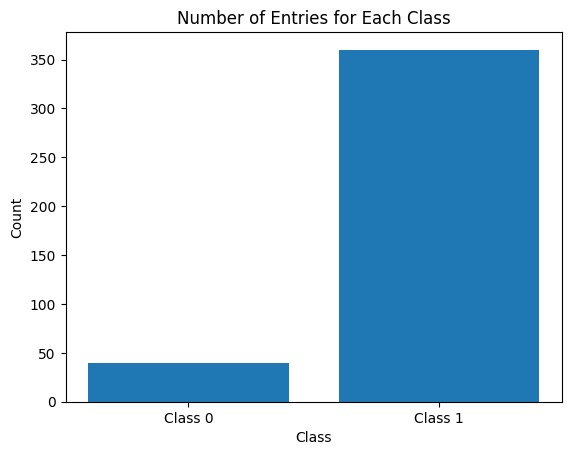

In [78]:

inspect = dl_train

# Initialize an empty list to hold all labels
all_labels = []

# Loop through the DataLoader
for i, (inputs, labels) in enumerate(inspect):
    all_labels.extend(labels.tolist())

# Count the occurrences of each class
count_classes = Counter(all_labels)

# Extract the classes and their counts for plotting
labels, values = zip(*count_classes.items())

# Create the bar plot
plt.bar(labels, values, tick_label=[f'Class {label}' for label in labels])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Number of Entries for Each Class')
plt.show()


### View specs

Make specs from dataloader. Change inspect to dl_test or dl_train

Batch: 5
Class distribution in this batch: tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
Sample: 9, which is class: 0


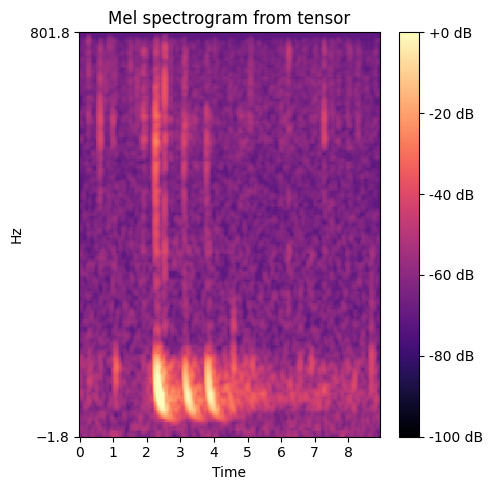

In [132]:
inspect = dl_test

# # Get the first batch of data
# first_batch = next(iter(dl_test))

# # Split the batch into features and labels
# features, labels = first_batch

# # Get the first element from the batch
# first_element_features = features[0]
# first_element_labels = labels[0]


import random

# Randomly choose a batch
random_batch_idx = random.randint(0, len(dl_train) - 1)
print(f'Batch: {random_batch_idx}')
for i, batch in enumerate(dl_train):
    if i == random_batch_idx:
        features, labels = batch
        break

# Randomly choose an element from the batch
print(f'Class distribution in this batch: {labels}')
random_element_idx = random.randint(0, len(features) - 1)
random_element_features = features[random_element_idx]
random_element_labels = labels[random_element_idx]
print(f'Sample: {random_element_idx}, which is class: {random_element_labels}')


### Do the plot
# Get the Mel spectrogram tensor for a dataset item (e.g., the first item)
mel_spectrogram_tensor = random_element_features #audio_dataset[10]

# Convert the tensor back to numpy for visualization and apply dB scaling
mel_spectrogram_np = mel_spectrogram_tensor.numpy()[0]  # Selecting one channel for visualization
mel_spectrogram_db = librosa.power_to_db(mel_spectrogram_np, ref=1.0)

# Plot the Mel spectrogram using the settings you provided
plt.figure(figsize=(5, 5))
librosa.display.specshow(mel_spectrogram_db, sr=1600, 
                         n_fft=2048, hop_length=64, win_length=1024,
                         y_axis='mel', x_axis='time',
                         vmin=-100, vmax=0,
                         cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram from tensor')
plt.tight_layout()
plt.show()
